# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

## <font style="color:green">Python Imports</font>

The following are common imports. If an import is only used by a function or two, then the import is declared in the function itself.

In [1]:
import os
import random
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools
import torch
import yaml
from IPython.utils import io
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from tqdm import tqdm


class classproperty(property):
    def __get__(self, cls, owner):
        return classmethod(self.fget).__get__(None, owner)()
    
tools.utils.seed_system(42)

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [66]:
class Data(object):
    __instance = None
    
    @classproperty
    def instance(cls):
        if cls.__instance == None:
            Data()
        return cls.__instance
    
    __data_dir = "home/hamdan/data"
    __img_dir = os.path.join(__data_dir, "imgs/imgs")
    __msk_dir = os.path.join(__data_dir, "masks/masks")
    __prv_img_csv_path = os.path.join(__data_dir, "test.csv")
    __pub_img_csv_path = os.path.join(__data_dir, "train.csv")

    @classproperty
    def data_dir(cls):
        return cls.__data_dir
    
    __classes = (        #  Value
    # ----------------   #  -----    
        "Background",    #    0
        "Person",        #    1
        "Bike",          #    2
        "Car",           #    3
        "Drone",         #    4
        "Boat",          #    5
        "Animal",        #    6
        "Obstacle",      #    7
        "Construction",  #    8
        "Vegetation",    #    9
        "Road",          #   10
        "Sky"            #   11
    )
    
    @classproperty
    def classes(cls):
        return cls.__classes
    
    @classproperty
    def num_classes(cls):
        return len(cls.__classes)
    
    @classproperty
    def image_dir(cls):
        return cls.__img_dir
    
    @classproperty
    def mask_dir(cls):
        return cls.__msk_dir
    
    @classmethod
    def class_index(cls, class_name):
        return cls.__classes.index(class_name)

    @classmethod
    def class_values(cls, classes):
        return [Data.class_index(cls) for cls in classes]
    
    __split_params = [
        (  2, 0.0000), (  3, 0.2000), (  5, 0.4000), (  7, 0.6000), ( 11, 0.8000),
        ( 13, 0.1000), ( 17, 0.3000), ( 19, 0.5000), ( 23, 0.7000), ( 29, 0.9000),
        ( 31, 0.0500), ( 37, 0.1500), ( 41, 0.2500), ( 43, 0.3500), ( 47, 0.4500),
        ( 53, 0.5500), ( 59, 0.6500), ( 61, 0.7500), ( 67, 0.8500), ( 71, 0.9500)
    ]
    
    @classmethod
    def split_params(cls, idx):
        return cls.__split_params[max(int(idx), 0)]
    
    ####################################################################################################
    
    def __init__(self):
        if Data.__instance != None:
            raise Exception("Data is a singleton. Use the Data.instance class property.")
        else:
            Data.__instance = self
            self.__prv_image_dict_list = self.__parse_image_data_file(Data.__prv_img_csv_path)
            self.__pub_image_dict_list = self.__parse_image_data_file(Data.__pub_img_csv_path)
            random.Random(42).shuffle(self.__pub_image_dict_list)

    def __parse_image_data_file(self, path):
        df = pd.read_csv(path, dtype={'ImageID': 'str'}, engine='python')
        image_dict_list = [self.__create_image_dict(idx, image_id) for idx, image_id in enumerate(df.values[:,0])]
        return image_dict_list

    def __create_image_dict(self, idx, image_id):
        img_dict = {}
        img_path = os.path.join(Data.__img_dir, image_id + ".jpg")
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image '{img_path}' is missing.")
        
        img_dict["id"] = idx
        img_dict["name"] = image_id
        img_dict["image_path"] = img_path
        img_dict["width"] = 1280
        img_dict["height"] = 720

        msk_path = os.path.join(Data.__msk_dir, image_id + ".png")
        if os.path.isfile(msk_path):
            img_dict["mask_path"] = msk_path
            
        return img_dict
    
    @property
    def prv_image_dict_len(self):
        return len(self.__prv_image_dict_list)
            
    @property
    def pub_image_dict_len(self):
        return len(self.__pub_image_dict_list)

    def get_prv_image_dict_list(self, indices=None):
        if indices is None:
            return self.__prv_image_dict_list
        return [self.__prv_image_dict_list[idx] for idx in indices]
    
    def get_pub_image_dict_list(self, indices=None):
        if indices is None:
            return self.__pub_image_dict_list
        return [self.__pub_image_dict_list[idx] for idx in indices]
    
    def split_pub_dataset(self, split_idx=0):
        split_len = len(self.__split_params)
        if split_idx >= split_len:
            raise ValueError(f"split_idx must an integer whose value is less than {split_len}")

        total_len = len(self.__pub_image_dict_list)
        valid_len = int(0.2 * total_len + 0.5)
        
        _, rel_off = Data.split_params(split_idx)
        abs_off = int(rel_off * total_len + 0.5)
        
        valid_idx = [(abs_off + idx) % total_len for idx in range(valid_len)]
        train_idx = [idx for idx in range(total_len) if idx not in valid_idx]
        
        if split_idx < 0:
            train_idx = self.__create_subset(train_idx, min(-0.01 * split_idx, 1.))
            valid_idx = self.__create_subset(valid_idx, min(-0.01 * split_idx, 1.))
        
        return train_idx, valid_idx
    
    @classmethod
    def __create_subset(cls, indices, subset_size=0.05):
        _, indices = np.unique([int(idx * subset_size) for idx in indices], return_index=True)
        return indices

In [3]:
def analyze_data_splitting(splits):
    data = Data.instance
    train_indices = []
    valid_indices = []
    for split_idx in range(splits):
        train_idx, valid_idx = data.split_pub_dataset(split_idx)
        train_indices.extend(train_idx)
        valid_indices.extend(valid_idx)

    def print_stats(label, image_indices):
        unique, count = np.unique(image_indices, return_counts=True)
        print(label, end=" - ")
        print(f"len: {len(image_indices):>6}", end=", ")
        print(f"min: {np.min(count):>2}", end=", ")
        print(f"max: {np.max(count):>2}", end=", ")
        print(f"ave: {np.mean(count):7.04f}")

    print(f"Concatentation of {splits} Splits")
    print_stats("train", train_indices)
    print_stats("valid", valid_indices)
    print()
    
analyze_data_splitting(5)

Concatentation of 5 Splits
train - len:  10485, min:  4, max:  5, ave:  4.0004
valid - len:   2620, min:  1, max:  1, ave:  1.0000



## <font style="color:green">ImageCache</font>

To decrease image and mask load and decoding time,

In [4]:
class ImageCache(object):
    __instance = None
    __cache_path = os.path.join(Data.data_dir, "cache.npy")
    
    @classproperty
    def instance(cls):
        if cls.__instance == None:
            ImageCache()
        return cls.__instance

    def __init__(self):
        if ImageCache.__instance != None:
            raise Exception("ImageCache is a singleton. Use the ImageCache.instance class property.")
        else:
            ImageCache.__instance = self
            if os.path.isfile(ImageCache.__cache_path):
                with open(ImageCache.__cache_path, "rb") as f:
                    self._img_data = np.load(f)
                    self._msk_data = np.load(f)               
            else:
                self.__create_cache()
                with open(ImageCache.__cache_path, "wb") as f:
                    np.save(f, self._img_data)
                    np.save(f, self._msk_data)
    
    def image(self, idx):
        return self._img_data[idx]
    
    def mask(self, idx):
        return self._msk_data[idx]

    def update(self, idx, image, mask):
        self._img_data[idx, ...] = image
        self._msk_data[idx, ...] = mask

    def __create_cache(self):
        image_dict_list = Data.instance.get_pub_image_dict_list()
        images = len(image_dict_list)
        self._msk_data = np.empty((images, 720, 1280), dtype=np.uint8)
        self._img_data = np.empty((images, 720, 1280, 3), dtype=np.uint8)
        pbar = tqdm(image_dict_list, desc="Loading", unit="image")
        for image_dict in pbar:
            idx = image_dict["id"]
            img = cv2.imread(image_dict["image_path"])
            self._img_data[idx, ...] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self._msk_data[idx, ...] = cv2.imread(image_dict["mask_path"], 0)
        pbar.close()


ImageCache.instance

## <font style="color:green">Dataset</font>

The `Dataset` class specializes PyTorch's `torch.utils.data.Dataset` class.

In [5]:
class Dataset(TorchDataset):
    def __init__(
        self,
        image_dict_list = None,
        classes = None,
        pixel_transforms = None,
        final_transforms = None,
        geometric_transforms = None,
        tile_transforms_list = None,
        binary_masks = False,
        use_image_cache = False
    ):
        self._image_dict_list = image_dict_list
        self._image_cache = ImageCache.instance if use_image_cache else None
        self._pixel_transforms = pixel_transforms
        self._final_transforms = final_transforms
        self._geometric_transforms = geometric_transforms
        self._tile_transforms_list = tile_transforms_list
        self._binary_masks = binary_masks

        self._classes = classes
        if classes is None:
            self._classes = Data.classes

        self._class_values = Data.class_values(self._classes)
        
        self._tiles_per_image = 1
        if tile_transforms_list is not None:
            self._tiles_per_image = len(tile_transforms_list)
    
    @property
    def classes(self):
        return self._classes
    
    @property
    def class_values(self):
        return self._class_values
    
    @classmethod
    def load(cls, image_dict, image_cache=None):
        if image_cache:
            idx = image_dict["id"]
            image = image_cache.image(idx)
            mask = image_cache.mask(idx)
        else:
            image = cv2.imread(image_dict["image_path"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = None
            if "mask_path" in image_dict:
                mask = cv2.imread(image_dict["mask_path"], 0)
        return image, mask
    
    def __len__(self):
        return len(self._image_dict_list) * self._tiles_per_image
    
    def __getitem__(self, idx):
        idx_dict = idx // self._tiles_per_image
        idx_tile = idx  % self._tiles_per_image
        image_dict = self._image_dict_list[idx_dict]       
        image, mask = Dataset.load(image_dict, self._image_cache)

        # handle the private dataset with images w/o masks
        if mask is None:
            mask = np.zeros_like(image)
            if self._geometric_transforms:
                result = self._geometric_transforms(image=image)
                image = result["image"]

            if self._tile_transforms_list:
                result = self._tile_transforms_list[idx_tile](image=image)
                image = result["image"]

            if self._pixel_transforms:
                result = self._pixel_transforms(image=image)
                image = result["image"]

            if self._final_transforms:
                result = self._final_transforms(image=image)
                image = result["image"]

        # handle the public dataset with images and masks
        else:
            if self._geometric_transforms:
                result = self._geometric_transforms(image=image, mask=mask)
                image, mask = result["image"], result["mask"]

            if self._tile_transforms_list:
                result = self._tile_transforms_list[idx_tile](image=image, mask=mask)
                image, mask = result["image"], result["mask"]

            if self._binary_masks:
                mask = [(mask == v) for v in self._class_values]
                mask = np.stack(mask, axis=-1).astype("float32")

            if self._pixel_transforms:
                result = self._pixel_transforms(image=image)
                image = result["image"]            

            if self._final_transforms:
                result = self._final_transforms(image=image, mask=mask)
                image, mask = result["image"], result["mask"]            

        return image, mask

## <font style="color:green">Copy-Paste Dataset</font>

The `CopyPasteDataset` class specializes PyTorch's `torch.utils.data.Dataset` class.

In [6]:
class CopyPasteDataset(TorchDataset):
    def __init__(
        self,
        image_dict_list = None,
        geometric_transforms = None
    ):
        self._image_dict_list = image_dict_list
        self._shuffle = list(range(len(image_dict_list)))
        self._geometric_transforms = geometric_transforms

    def shuffle(self):
        random.shuffle(self._shuffle)

    def __load(self, image_dict):
        image = cv2.imread(image_dict["image_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(image_dict["mask_path"], 0)
        return image, mask
    
    def __len__(self):
        return len(self._image_dict_list)
    
    def __getitem__(self, idx):
        dict_copy = self._image_dict_list[self._shuffle[idx]]
        image_copy, mask_copy = self.__load(dict_copy)

        dict_paste = self._image_dict_list[idx]
        image_paste, mask_paste = self.__load(dict_paste)

        if self._geometric_transforms:
            result = self._geometric_transforms(image=image_copy, mask=mask_copy)
            image_copy, mask_copy = result["image"], result["mask"]

            result = self._geometric_transforms(image=image_paste, mask=mask_paste)
            image_paste, mask_paste = result["image"], result["mask"]

        idx = np.array(dict_paste["id"])
        pixel_counts = np.array(dict_copy["mask_pixel_counts"])
        return idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>


## <font style="color:green">Visualizer</font>

The `Visualizer` class is static and contains to public methods: `visualize_images` and `blend_images`. 

Samples without Alpha Blending


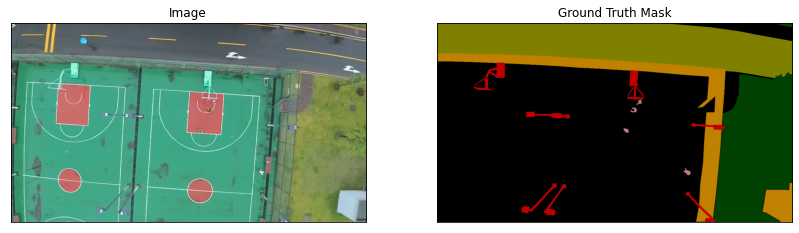

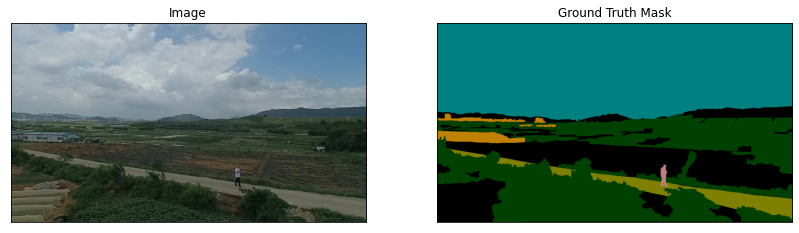

Samples with Alpha Blending


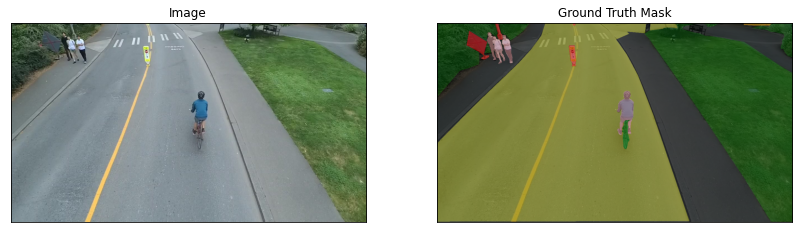

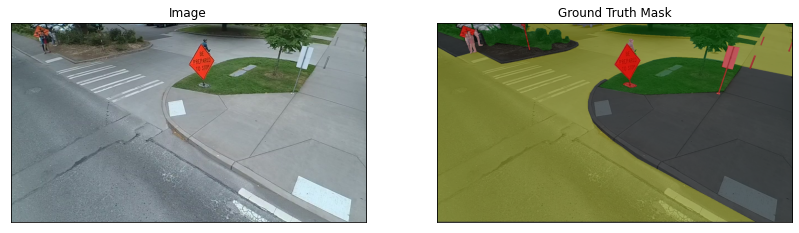

In [7]:
class Visualizer(object):
    __class_colors = (    #  Class 
    #------------------   #  -------------
        (  0,   0,   0),  #  Background
        (192, 128, 128),  #  Person
        (  0, 128,   0),  #  Bike
        (128, 128, 128),  #  Car
        (128,   0,   0),  #  Drone
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  Vegetation
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    )
    
    @classproperty
    def class_colors(cls):
        return cls.__class_colors
    
    @classmethod
    def create_color_mask(cls, mask):       
        return np.array(Visualizer.__class_colors)[mask.ravel()].reshape((*mask.shape, 3))
    
    @classmethod
    def _process_image(cls, name, image):
        is_path = isinstance(image, str)
        is_data = isinstance(image, np.ndarray)
        is_tensor = isinstance(image, torch.Tensor)
        if not is_path and not is_data and not is_tensor:
            raise ValueError(f"{name} must be a string path, numpy.ndarray, or torch.Tensor.")
            
        if "mask" in name:
            if is_tensor:
                image = image.cpu().numpy()
            elif is_path:
                image = cv2.imread(image, 0)
            image = cls.create_color_mask(image)
        elif is_tensor:
            image = image.cpu().numpy()
        elif is_path:
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        return image
    
    @classmethod
    def visualize_images(cls, **images):
        """Plot images in one row."""
        n = len(images)
        plt.figure(figsize=(14, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(cls._process_image(name, image))                   
        plt.show()

    @classmethod
    def blend_images(cls, image, pr_mask=None, gt_mask=None, alpha=0.5):
        ncols = 1
        if pr_mask is not None: ncols += 1
        if gt_mask is not None: ncols += 1
        if ncols == 1:
            raise ValueError("A predicted or ground truth mask is required")
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, ncols, 1)
        plt.xticks([])
        plt.yticks([])
        plt.title("Image")
        plt.imshow(cls._process_image("image", image))

        def blend(image, mask, title, alpha):
            plt.xticks([])
            plt.yticks([])
            plt.title(title)
            plt.imshow(cls._process_image("image", image))
            plt.imshow(cls._process_image("mask", mask), alpha=alpha)
        
        index = 1
        if gt_mask is not None:
            index += 1
            plt.subplot(1, ncols, index)
            blend(image, gt_mask, "Ground Truth Mask", alpha)
        if pr_mask is not None:
            index += 1
            plt.subplot(1, ncols, index)
            blend(image, pr_mask, "Predicted Mask", alpha)
        

print(f"Samples without Alpha Blending")
for image_dict in Data.instance.get_pub_image_dict_list(range(0, 2)):
    Visualizer.visualize_images(image=image_dict["image_path"], ground_truth_mask=image_dict["mask_path"])
print(f"Samples with Alpha Blending")
for image_dict in Data.instance.get_pub_image_dict_list(range(2, 4)):
    Visualizer.blend_images(image=image_dict["image_path"], gt_mask=image_dict["mask_path"], alpha=0.6)


# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [12]:
class IouAndDiceMetrics(object):
    # ToDo: If needed, add ignore classes to constructor.
    def __init__(self, num_classes, image_width=1280, image_height=720, eps=1e-7):
        self._eps = eps
        self._num_classes = num_classes
        self._image_width = image_width
        self._image_height = image_height
        self.reset()
        
    def reset(self):
        self._n = 0
        self._iou_totals = np.array([0.] * self._num_classes)
        self._dice_totals = np.array([0.] * self._num_classes)
        
    def add(self, y_pred, y_true):
        from torch.nn import functional as f
        batch_size, num_classes, image_height, image_width = tuple(y_true.shape)
        
        # remove padding so it does impact metrics
        if (image_height == 736):
            y_pred = y_pred.narrow(2, 8, self._image_height)
            y_true = y_true.narrow(2, 8, self._image_height)
                
        # flatten height and width and one-hot encode prediction
        y_pred = y_pred.view(batch_size, num_classes, -1)
        y_true = y_true.view(batch_size, num_classes, -1)
        y_pred = f.one_hot(y_pred.argmax(dim=1), num_classes).transpose(1, 2).type_as(y_true)
        
        # compute the intersection (|y_pred * y_true|) and cardinality (|y_pred| + |y_true|)
        cardinality = torch.sum(y_pred + y_true, dim=2)
        intersection = torch.sum(y_pred * y_true, dim=2)
        
        # compute "per class" IoU and Dice coefficients for each prediction and sum over batch
        iou = torch.sum((intersection + self._eps) / (cardinality - intersection + self._eps), dim=0)
        dice = torch.sum((2. * intersection + self._eps) / (cardinality + self._eps), dim=0)
        
        # update the count and totals
        self._n += batch_size
        self._iou_totals += iou.data.cpu().numpy()
        self._dice_totals += dice.data.cpu().numpy()
        
    @property
    def iou(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = self._iou_totals / self._n
            return np.nanmean(iou), iou
        
    @property
    def dice(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            dice = self._dice_totals / self._n
            return np.nanmean(dice), dice

# <font style="color:green">Import Pretrained Model</font>



In [58]:
from segmentation_models_pytorch import DeepLabV3Plus 
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [14]:
class FixedLengthIterator(object):
    def __init__(self, it, length):
        import itertools
        self._it = itertools.cycle(it)
        self._length = length

    def __len__(self):
        return self._length

    def __iter__(self):
        self._index = 0
        return self

    def __next__(self):
        self._index += 1
        if self._index > self._length:
            raise StopIteration()
        return next(self._it)


class SimpleStatistics(object):
    def __init__(self, alpha=0.3):
        self._alpha = 0.3
        self.reset()

    def reset(self):
        self._n = 0
        self._ema = 0.
        self._total = 0.
        self._values = []

    @property
    def samples(self):
        return self._n

    @property
    def first(self):
        return self._values[0] if self._n > 0 else float("nan")

    @property
    def last(self):
        return self._values[-1] if self._n > 0 else float("nan")

    @property
    def min(self):
        return min(self._values) if self._n > 0 else float("nan")

    @property
    def max(self):
        return max(self._values) if self._n > 0 else float("nan")

    @property
    def mean(self):
        return self._total / self._n if self._n > 0 else float("nan")

    @property
    def ema(self):
        return self._ema if self._n > 0 else float("nan")

    @property
    def values(self):
        return self._values

    def add(self, x):
        beta = 1. - self._alpha
        self._total += x
        self._values.append(x)
        self._ema = self._alpha * x + (1 - self._alpha) * self._ema if self._n > 0 else x
        self._n += 1
        return self.mean

## <font style="color:green">Configuration</font>



In [15]:
class Config(dict):
    def __init__(self, d=None):
        if isinstance(d, dict):
            self.merge(d)
        elif not None:
            raise ValueError("Parameter d must be None or a dictionary.")
    
    def merge(self, d):
        for k, v in d.items():
            if not isinstance(v, dict):
                self[k] = v
            else:
                if k not in self:
                    self[k] = Config(v)
                else:
                    if not isinstance(self[k], dict):
                        raise ValueError(f"Cannot merge dictionary {k} with a non-dictionary value.")
                    self[k].merge(v)
    
    def __getattr__(self, name):
        if name in self:
            return self[name]
        raise AttributeError(name)

    def __setattr__(self, name, value):
        self[name] = value

    def __str__(self):
        def _enumerate(d, prefix=""):
            output = []
            for k, v in d.items():
                if isinstance(v, dict):
                    output.extend(_enumerate(v, prefix + k + '.'))
                else:
                    output.append(f"{prefix + k}: {v}")
            return output
        return '\n'.join(_enumerate(self))

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, super(CfgNode, self).__repr__())

    @classmethod
    def from_dict(cls, d):
        return Config(d)
    
    @classmethod
    def from_yaml(cls, s):
        return Config(cls.__cleanup_yaml(yaml.safe_load(s)))
        
    @classmethod
    def __cleanup_yaml(cls, d):
        for k, v in d.items():
            if isinstance(v, dict):
                cls.__cleanup_yaml(v)
            elif isinstance(v, str):
                if v.lower() == "none":
                    d[k] = None
                elif v.startswith('('):
                    try:
                        d[k] = eval(v)
                    except Exception:
                        pass
        return d
        
    @classmethod
    def default(cls):
        return cls.from_yaml(cls.__default)
        
    __default = """
        EXPERIMENT:
          PREFIX: "PREFIX"
          SUFFIX: "SUFFIX"
          LOAD_PREV: None
        MODEL:
          NAME: "FPN"
          ABBR: "FPN"
          ENCODER: 
            NAME: "efficientnet-b3"
            ABBR: "EFF3"
            WEIGHTS: "imagenet"
          ACTIVATION: None
        DATASETS:
          SPLIT_INDEX: 0
          CLASSES: "all"
          AUGMENTATION:
            HORIZONTAL_FLIP:
              ENABLE: False
              PROBABILITY: 0.5
            SHIFT_SCALE_ROTATE:
              ENABLE: False
              PROBABILITY: 0.5
              SHIFT_LIMIT: 0.0625
              SCALE_LIMIT: 0.1
              ROTATE_LIMIT: 10
            TILE:
              ENABLE: False
              WIDTH: 416
              HEIGHT: 224
              SETS: [[1280, 720, 4, 4], [640, 360, 2, 2]]
            COPY_PASTE:
                ENABLE: False
                PROBABILITY: 0.667
                MAX_REL_AREA: 0.5
                MAX_CLASSES: 3
                CLASSES: "all"
                VARIANT: "random"
                DELAY: 1
            COLOR:
              ENABLE: False
              PROBABILITY: 0.9
              CLAHE:
                ENABLE: True
                PROBABILITY: 1.0
                CLIP_LIMIT: 4.0
              BRIGHTNESS_CONTRAST:
                ENABLE: True
                PROBABILITY: 1.0
                BRIGHTNESS_LIMIT: 0.2
                CONTRAST_LIMIT: 0.2
                BRIGHTNESS_BY_MAX: True
              HUE_SATURATION_VALUE:
                ENABLE: True
                PROBABILITY: 1.0
                HUE_SHIFT_LIMIT: 20
                SAT_SHIFT_LIMIT: 30
                VAL_SHIFT_LIMIT: 20
            GAUSSIAN_NOISE:
                ENABLE: False
                PROBABILITY: 0.2
                VAR_LIMIT: (10.0, 50.0)
                MEAN: 0.0
        DATALOADERS:
          TRAIN:
            BATCH_SIZE: 2
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: True
            DROP_LAST: True
          COPY_PASTE:
            BATCH_SIZE: 1
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: False
            DROP_LAST: False
          VALID:
            BATCH_SIZE: 4
            NUM_WORKERS: 8
            SHUFFLE: False
            PIN_MEMORY: True
            DROP_LAST: False
          VISUALIZE:
            BATCH_SIZE: 8
            NUM_WORKERS: 8
            SHUFFLE: True
            PIN_MEMORY: FALSE
            DROP_LAST: True
        LOSS_FN:
            WEIGHTS: None
            ADAPTIVE:
                ENABLE: False
                MAX_WEIGHT: 3.0
        SOLVER:
          MAX_LR: 1.0e-3
          MIN_LR: 1.0e-8
          PATIENCE: 5
          NUM_EPOCHS: 100
          ANN_EPOCHS: 4
        """

## <font style="color:green">Experiment Data</font>

Instances of the `ExpData` class creates training (train), validation (valid), and test (test) image dictionary lists, datasets, and data loaders. 

In [16]:
class ExpData(object):
    def __init__(self, cfg):
        self._seed, _ = Data.split_params(cfg.DATASETS.SPLIT_INDEX)
        tools.utils.seed_system(self._seed)
        self._cfg = cfg
        self._test_net_loader = None
        self._test_viz_loader = None
        self._test_net_dataset = None
        self._test_viz_dataset = None
        self._valid_net_loader = None
        self._valid_viz_loader = None
        self._valid_net_dataset = None
        self._valid_viz_dataset = None
        self._train_net_loader = None
        self._train_viz_loader = None
        self._train_net_dataset = None
        self._train_viz_dataset = None
        self._train_copy_paste_dataset = None
        self._train_copy_paste_loader = None
        self._train_idx, self._valid_idx = Data.instance.split_pub_dataset(cfg.DATASETS.SPLIT_INDEX)
        self._test_image_dict_list = Data.instance.get_prv_image_dict_list()
        self._valid_image_dict_list = Data.instance.get_pub_image_dict_list(self._valid_idx)
        self._train_image_dict_list = Data.instance.get_pub_image_dict_list(self._train_idx)
        self._encoder_preprocessing_fn = get_preprocessing_fn(cfg.MODEL.ENCODER.NAME, cfg.MODEL.ENCODER.WEIGHTS)
        self._classes = cfg.DATASETS.CLASSES
        if self._classes == "all":
            self._classes = Data.classes

    @property
    def test_image_dict_list(self):
        return self._test_image_dict_list
    
    @property
    def valid_image_dict_list(self):
        return self._valid_image_dict_list
    
    @property
    def train_image_dict_list(self):
        return self._train_image_dict_list
    
    @property
    def test_net_dataset(self):
        if self._test_net_dataset is None:
            self._test_net_dataset = ExpData._create_dataset(
                image_dict_list = self._test_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = False
            )
        return self._test_net_dataset
    
    @property
    def test_viz_dataset(self):
        if self._test_viz_dataset is None:
            self._test_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._test_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = None,
                use_image_cache = False
            )
        return self._test_viz_dataset

    @property
    def valid_net_dataset(self):
        if self._valid_net_dataset is None:
            self._valid_net_dataset = ExpData._create_dataset(
                image_dict_list = self._valid_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = not self._cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE
            )
        return self._valid_net_dataset
    
    @property
    def valid_viz_dataset(self):
        if self._valid_viz_dataset is None:
            self._valid_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._valid_image_dict_list, 
                classes = self._classes, 
                augmentation = None, 
                encoder_preprocessing_fn = None,
                use_image_cache = not self._cfg.DATASETS.AUGMENTATION.COPY_PASTE.ENABLE
            )
        return self._valid_viz_dataset

    @property
    def train_net_dataset(self):
        if self._train_net_dataset is None:
            self._train_net_dataset = ExpData._create_dataset(
                image_dict_list = self._train_image_dict_list, 
                classes = self._classes, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
                encoder_preprocessing_fn = self._encoder_preprocessing_fn,
                use_image_cache = True
            )
        return self._train_net_dataset
    
    @property
    def train_viz_dataset(self):
        if self._train_viz_dataset is None:
            self._train_viz_dataset = ExpData._create_dataset(
                image_dict_list = self._train_image_dict_list, 
                classes = self._classes, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
                encoder_preprocessing_fn = None,
                use_image_cache = True
            )
        return self._train_viz_dataset

    @property
    def train_copy_paste_dataset(self):
        if self._train_copy_paste_dataset is None:
            self._train_copy_paste_dataset = ExpData._create_copy_and_paste_dataset(
                image_dict_list = self._train_image_dict_list, 
                augmentation = self._cfg.DATASETS.AUGMENTATION, 
            )
        return self._train_copy_paste_dataset

    @property
    def test_net_loader(self):
        if self._test_net_loader is None:
            self._test_net_loader = ExpData._create_loader(
                dataset = self.test_net_dataset, 
                params = self._cfg.DATALOADERS.VALID
            )
        return self._test_net_loader

    @property
    def test_viz_loader(self):
        if self._test_viz_loader is None:
            self._test_viz_loader = ExpData._create_loader(
                dataset = self.test_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._test_viz_loader
    
    @property
    def valid_net_loader(self):
        if self._valid_net_loader is None:
            self._valid_net_loader = ExpData._create_loader(
                dataset = self.valid_net_dataset, 
                params = self._cfg.DATALOADERS.VALID
            )
        return self._valid_net_loader

    @property
    def valid_viz_loader(self):
        if self._valid_viz_loader is None:
            self._valid_viz_loader = ExpData._create_loader(
                dataset = self.valid_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._valid_viz_loader

    @property
    def train_net_loader(self):
        if self._train_net_loader is None:
            self._train_net_loader = ExpData._create_loader(
                dataset = self.train_net_dataset, 
                params = self._cfg.DATALOADERS.TRAIN
            )
        return self._train_net_loader

    @property
    def train_viz_loader(self):
        if self._train_viz_loader is None:
            self._train_viz_loader = ExpData._create_loader(
                dataset = self.train_viz_dataset, 
                params = self._cfg.DATALOADERS.VISUALIZE
            )
        return self._train_viz_loader

    @property
    def train_copy_paste_loader(self):
        if self._train_copy_paste_loader is None:
            self._train_copy_paste_loader = ExpData._create_loader(
                dataset = self.train_copy_paste_dataset,
                params = self._cfg.DATALOADERS.COPY_PASTE
            )
        return self._train_copy_paste_loader

    @classmethod
    def _create_dataset(cls, image_dict_list, classes, augmentation, encoder_preprocessing_fn, use_image_cache):
        geometric_transforms = None
        if augmentation is None or not augmentation.COPY_PASTE.ENABLE:
            geometric_transforms = cls.create_geometric_transforms(augmentation)
        tile_transforms_list = cls.create_tile_transforms_list(augmentation)
        pixel_transforms = cls.create_pixel_transforms(augmentation)
        final_transforms = cls.create_final_transforms(augmentation, encoder_preprocessing_fn)
        return Dataset(
            image_dict_list,
            classes = classes,
            pixel_transforms = pixel_transforms,
            final_transforms = final_transforms,
            geometric_transforms = geometric_transforms,
            tile_transforms_list = tile_transforms_list,
            binary_masks = encoder_preprocessing_fn is not None,
            use_image_cache = use_image_cache
        )

    @classmethod
    def _create_copy_and_paste_dataset(cls, image_dict_list, augmentation):
        return CopyPasteDataset(
            image_dict_list,
            geometric_transforms = cls.create_geometric_transforms(augmentation)
        )

    @classmethod
    def _create_loader(cls, dataset, params):
        return DataLoader(
            dataset = dataset, 
            batch_size = params.BATCH_SIZE,
            shuffle = params.SHUFFLE,
            num_workers = params.NUM_WORKERS,
            pin_memory = params.PIN_MEMORY,
            drop_last = params.DROP_LAST
        )

    @classmethod
    def create_geometric_transforms(cls, augmentation=None):
        import albumentations as albu
        geometric_transforms = []
        if augmentation:
            if augmentation.HORIZONTAL_FLIP.ENABLE:
                geometric_transforms.append(albu.HorizontalFlip(p=augmentation.HORIZONTAL_FLIP.PROBABILITY))           
            if augmentation.SHIFT_SCALE_ROTATE.ENABLE:
                geometric_transforms.append(albu.ShiftScaleRotate(
                    shift_limit = augmentation.SHIFT_SCALE_ROTATE.SHIFT_LIMIT,
                    scale_limit = augmentation.SHIFT_SCALE_ROTATE.SCALE_LIMIT,
                    rotate_limit = augmentation.SHIFT_SCALE_ROTATE.ROTATE_LIMIT,
                    p = augmentation.SHIFT_SCALE_ROTATE.PROBABILITY
                ))
        return albu.Compose(geometric_transforms) if len(geometric_transforms) > 0 else None

    @classmethod
    def create_tile_transforms_list(cls, augmentation=None):
        import albumentations as albu
        tile_transforms_list = []
        if augmentation and augmentation.TILE.ENABLE:
            tile_width = augmentation.TILE.WIDTH
            tile_height = augmentation.TILE.HEIGHT
            for image_width, image_height, cols, rows in augmentation.TILE.SETS:
                for row in range(rows):
                    y_min = row * (image_height - tile_height) // (rows - 1)
                    y_max = y_min + tile_height # - 1
                    for col in range(cols):
                        x_min = col * (image_width - tile_width) // (cols - 1)
                        x_max = x_min + tile_width # - 1
                        tile_transforms = []
                        if image_width != 1280 or image_height != 720:
                            tile_transforms.append(albu.Resize(
                                height = image_height,
                                width = image_width,
                                always_apply = True
                            ))
                        tile_transforms.append(albu.Crop(
                            x_min = x_min,
                            y_min = y_min,
                            x_max = x_max,
                            y_max = y_max,
                            always_apply = True
                        ))
                        tile_transforms_list.append(albu.Compose(tile_transforms))
        return tile_transforms_list if len(tile_transforms_list) > 0 else None

    @classmethod
    def create_pixel_transforms(cls, augmentation=None):
        import albumentations as albu
        
        def transpose(x, **kwargs):
            return x.transpose(2, 0, 1).astype('float32')    
        
        pixel_transforms = []

        if augmentation and augmentation.COLOR.ENABLE:
            color_transforms = []
            
            if augmentation.COLOR.CLAHE.ENABLE:
                color_transforms.append(albu.CLAHE(
                    clip_limit = augmentation.COLOR.CLAHE.CLIP_LIMIT,
                    p = augmentation.COLOR.CLAHE.PROBABILITY
                ))

            if augmentation.COLOR.BRIGHTNESS_CONTRAST.ENABLE:
                color_transforms.append(albu.RandomBrightnessContrast(
                    brightness_limit = augmentation.COLOR.BRIGHTNESS_CONTRAST.BRIGHTNESS_LIMIT,
                    contrast_limit = augmentation.COLOR.BRIGHTNESS_CONTRAST.CONTRAST_LIMIT,
                    brightness_by_max = augmentation.COLOR.BRIGHTNESS_CONTRAST.BRIGHTNESS_BY_MAX,
                    p = augmentation.COLOR.BRIGHTNESS_CONTRAST.PROBABILITY
                ))

            if augmentation.COLOR.HUE_SATURATION_VALUE.ENABLE:
                color_transforms.append(albu.HueSaturationValue(
                    hue_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.HUE_SHIFT_LIMIT,
                    sat_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.SAT_SHIFT_LIMIT,
                    val_shift_limit = augmentation.COLOR.HUE_SATURATION_VALUE.VAL_SHIFT_LIMIT,
                    p = augmentation.COLOR.HUE_SATURATION_VALUE.PROBABILITY
                ))

            if len(color_transforms) > 0:
                pixel_transforms.append(albu.OneOf(color_transforms, p=augmentation.COLOR.PROBABILITY))
            
        if augmentation and augmentation.GAUSSIAN_NOISE.ENABLE:
            pixel_transforms.append(albu.GaussNoise(
                var_limit = augmentation.GAUSSIAN_NOISE.VAR_LIMIT,
                mean = augmentation.GAUSSIAN_NOISE.MEAN,
                p = augmentation.GAUSSIAN_NOISE.PROBABILITY
            ))
        
        return albu.Compose(pixel_transforms) if len(pixel_transforms) > 0 else None

    @classmethod
    def create_final_transforms(cls, augmentation=None, encoder_preprocessing_fn=None):
        import albumentations as albu
        
        def transpose(x, **kwargs):
            return x.transpose(2, 0, 1).astype('float32')    
        
        final_transforms = []

        # !!! image and mask dimensions must be divisible by 32 !!!
        if augmentation is None or not augmentation.TILE.ENABLE:
            final_transforms.append(albu.PadIfNeeded(min_height=736, min_width=1280, always_apply=True))
            
        if encoder_preprocessing_fn:
            final_transforms.append(albu.Lambda(image=encoder_preprocessing_fn, name="encoder_preprocessing_fn"))
            final_transforms.append(albu.Lambda(image=transpose, mask=transpose, name="transpose"))
            
        return albu.Compose(final_transforms) if len(final_transforms) > 0 else None        

## <font style="color:green">Train & Inferencer</font>

Instances of the `Inferencer` class load a trained model and predict the mask(s) of a specified image(s). The `predict` method accepts image dictionary, numpy, and tensor arguments and my optionally perform an activation on the resulting prediction.

In [17]:
class Inferencer(ExpData):
    _output_dir = "./output"
    _best_model = "best_model.pth"
    _last_model = "last_model.pth"

    def __init__(self, cfg):
        super().__init__(cfg)
        self._model = None
        self._name = Inferencer.name(cfg)
        self._output_dir = Inferencer.output_dir(cfg)
        os.makedirs(self._output_dir, exist_ok=True)
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._init_continued(cfg)
    
    def _init_continued(self, cfg):
        path = os.path.join(self._output_dir, Inferencer._best_model)
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model_state_dict"])

    @classmethod
    def name(cls, cfg):
        return f"{cfg.EXPERIMENT.PREFIX}-{cfg.MODEL.ABBR}-{cfg.MODEL.ENCODER.ABBR}-{cfg.EXPERIMENT.SUFFIX}"
        
    @classmethod
    def output_dir(cls, cfg):
        return os.path.join(cls._output_dir, cls.name(cfg))
        
    @property
    def device(self):
        return self._device
    
    @property
    def model(self):
        if self._model is None:
            self._model = self._create_model()
            self._model.to(self._device)
        return self._model
    
    def __get_image(self, image_dict, image_dict_list, dataset):
        try:
            idx = image_dict_list.index(image_dict)
            image, _ = dataset[idx]
            return image
        except ValueError:
            return None

    def predict(self, images, activation=None):       
        from torch.nn import functional as f

        # prepare input
        if isinstance(images, torch.Tensor):
            images = images.to(self.device)
        elif isinstance(images, np.ndarray):
            images = torch.from_numpy(images).to(self.device)
        elif isinstance(images, dict):
            image = self.__get_image(images, self.valid_image_dict_list, self.valid_net_dataset)
            if image is None:
                image = self.__get_image(images, self.test_image_dict_list, self.test_net_dataset)
                if image is None:
                    raise ValueError("unknown image dictionary")
            images = torch.from_numpy(image).to(self.device)
        else:
            raise ValueError("images must be a torch.Tensor, np.ndarray, or image dictionary")

        # add batch size of 1 if individual image
        squeeze = False
        dims = len(images.shape)
        if dims == 3:
            squeeze = True
            images = images.unsqueeze(0)
        elif dims < 3 or dims > 4:
            raise ValueError("images must have three color channels")
            
        # get prediction
        self.model.eval()
        with torch.no_grad():        
            probs = self.model(images)
        probs = probs.narrow(2, 8, 720)
        
        # apply activitation
        if activation is None:
            output = probs
        elif activation == "argmax":
            output = probs.argmax(dim=1).byte()
        elif activation == "softmax":
            output = f.softmax(probs, dim=1)
        elif activation == "one_hot":
            batch_size, num_classes, image_height, image_width = tuple(probs.shape)
            probs = probs.view(batch_size, num_classes, -1)
            output = f.one_hot(probs.argmax(dim=1), num_classes).transpose(1, 2).byte()
            output = output.view(batch_size, num_classes, image_height, image_width)
        else:
            raise ValueError("activation should be 'argmax', 'softmax', 'one_hot', or None")
        
        # prepare output
        if squeeze:
            output = output.squeeze(0)

        return output
        
    def _create_model(self):
        model_class = getattr(sys.modules[__name__], self._cfg.MODEL.NAME)
        return model_class(
            encoder_name = self._cfg.MODEL.ENCODER.NAME,
            encoder_weights = self._cfg.MODEL.ENCODER.WEIGHTS,
            classes = len(self._classes),
            activation = self._cfg.MODEL.ACTIVATION
        )
    
    @classmethod
    def _create_progress_loader(cls, description, data_loader):
        return tqdm(
            iterable = data_loader, 
            bar_format = "{l_bar}{bar}| {n_fmt:>4}/{total_fmt:4} [{elapsed}<{remaining}, {rate_fmt}{postfix}]", 
            desc = description, 
            mininterval = 1., 
            unit = "batch"
        )

## <font style="color:green">Trainer</font>

Instances of the `Trainer` class load a pretrained encoder or previously trained model to fine tune the model on the Aeroscapes dataset.

In [18]:
class Trainer(Inferencer):
    _runs_dir = "./runs"

    def __init__(self, cfg):
        super().__init__(cfg)
        self._loss_fn = None
        self._optimizer = None
        self._scheduler = None
        self._runs_dir = os.path.join(Trainer._runs_dir, self._name)
        # Instantiating the model, optimizer, and LR scheduler may produce output.
        with io.capture_output():
            model = self.model
            optimizer = self.optimizer
            scheduler = self.scheduler

    def _init_continued(self, cfg):
        if cfg.EXPERIMENT.LOAD_PREV:
            try:     
                with io.capture_output():
                    path = os.path.join(Inferencer._output_dir, cfg.EXPERIMENT.LOAD_PREV, Inferencer._best_model)
                    checkpoint = torch.load(path)
                    self.model.load_state_dict(checkpoint["model_state_dict"])
            except Exception:
                print(f"Cannot load experiment's{cfg.EXPERIMENT.LOAD_PREV} model for additional training. ")
                printf("Please verify this experiment has been run and its output has not moved.")
                exit()

    @property
    def loss_fn(self):
        if self._loss_fn is None:
            self._loss_fn = self._create_loss_fn()
        return self._loss_fn
    
    @property
    def optimizer(self):
        if self._optimizer is None:
            self._optimizer = self._create_optimizer()
        return self._optimizer
    
    @property
    def scheduler(self):
        if self._scheduler is None:
            self._scheduler = self._create_scheduler()
        return self._scheduler

    @classmethod
    def _compute_loss_fn_weights(cls, metrics, max_weight):
        _, scores = metrics.dice
        return [(1. - score) * (max_weight - 1.) + 1. for score in scores]
    
    @classmethod
    def _compute_copy_paste_weights(cls, metrics):
        _, scores = metrics.dice
        weights = 1. - scores
        weights = 100. * weights / (np.sum(weights) + 0.01)
        return [int(max(weight, 1.) + 0.5) for weight in weights]                   
    
    @classmethod
    def _synthesize_data(
        cls, 
        epoch_num, 
        copy_paste_loader,
        copy_paste_params,
        weights = None,
        show_progress = False
    ):
        if weights is None:
            weights = [1] * Data.num_classes

        included_class_values = list(range(Data.num_classes))
        if not isinstance(copy_paste_params.CLASSES, str) or copy_paste_params.CLASSES.lower() != "all":
            included_class_values = Data.class_values(copy_paste_params.CLASSES)

        loader_pbar = copy_paste_loader
        if show_progress:
            loader_pbar = cls._create_progress_loader(f"Copy-Paste {epoch_num:03d}", copy_paste_loader)

        prob = copy_paste_params.PROBABILITY
        copy_paste_loader.dataset.shuffle()
        count_thd = int(copy_paste_params.MAX_REL_AREA * 1280 * 720)
        for idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts in loader_pbar:
            idx = int(idx)
            image_copy = image_copy.squeeze().numpy()
            mask_copy = mask_copy.squeeze().numpy()
            mask_paste = mask_paste.squeeze().numpy()
            image_paste = image_paste.squeeze().numpy()
            pixel_counts = pixel_counts.squeeze().numpy()

            if (random.random() >= prob):
                # do not copy and paste classes
                image_comp, mask_comp = image_paste, mask_paste
            else:
                # generated a weighted list of choices
                class_value_choices = []
                for class_value, (pixel_count, weight) in enumerate(zip(pixel_counts, weights)):
                    if class_value in included_class_values and pixel_count > 0:
                        class_value_choices.extend([class_value] * weight)
                random.shuffle(class_value_choices)

                # select a random number of unique choices whose area does not exceed the count threshold
                count = 0
                class_values = []
                max_classes = random.randint(1, copy_paste_params.MAX_CLASSES)
                for class_value in class_value_choices:
                    pixel_count = pixel_counts[class_value]
                    if count + pixel_count <= count_thd and class_value not in class_values:
                        count += pixel_count
                        class_values.append(class_value)
                        if len(class_values) >= max_classes:
                            break

                # create the compose image and mask
                if len(class_values) == 0:
                    image_comp, mask_comp = image_paste, mask_paste
                else:
                    image_comp, mask_comp = copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values)

            ImageCache.instance.update(idx, image_comp, mask_comp)

        if show_progress:
            loader_pbar.close()

    @classmethod
    def _do_train_cycle(
        cls, 
        epoch_num, 
        model,
        device,
        loss_fn,
        optimizer,
        scheduler,
        data_loader,
        metrics = None, 
        loss_stats = None,
        show_progress = False,
        annealing = False
    ):
        cycle_pbar = data_loader
        if show_progress:
            action = "  Training" if not annealing else " Annealing"
            cycle_pbar = cls._create_progress_loader(f"{action} {epoch_num:03d}", data_loader)

        model.train()
        for images, gt_masks in cycle_pbar:
            optimizer.zero_grad()
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            pr_masks = model(images)
            loss = loss_fn(pr_masks, gt_masks)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            mean_loss = float("nan")
            if loss_stats:
                loss_stats.add(float(loss))
                mean_loss = loss_stats.mean

            mean_dice = float("nan")
            if metrics:
                metrics.add(pr_masks, gt_masks)
                mean_dice, _ = metrics.dice
                
            if show_progress:
                cycle_pbar.set_postfix_str(f"loss={loss_stats.mean:.5f}, dice={mean_dice:.5f}")

        if show_progress:
            cycle_pbar.close()

    @classmethod
    def _do_valid_cycle(
        cls, 
        epoch_num, 
        model,
        device,
        loss_fn,
        data_loader,
        metrics = None, 
        loss_stats = None,
        show_progress = False
    ):
        cycle_pbar = data_loader
        if show_progress:
            cycle_pbar = cls._create_progress_loader(f"Validating {epoch_num:03d}", data_loader)
            
        model.eval()
        for images, gt_masks in cycle_pbar:
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            with torch.no_grad():        
                pr_masks = model(images)
                loss = loss_fn(pr_masks, gt_masks)

            mean_loss = float("nan")
            if loss_stats:
                loss_stats.add(float(loss))
                mean_loss = loss_stats.mean
            
            mean_dice = float("nan")
            if metrics:
                metrics.add(pr_masks, gt_masks)
                mean_dice, _ = metrics.dice
            
            if show_progress:
                cycle_pbar.set_postfix_str(f"loss={loss_stats.mean:.5f}, dice={mean_dice:.5f}")
                
        if show_progress:
            cycle_pbar.close()
    
    def train(self):
        from torch.utils.tensorboard import SummaryWriter 
        tools.utils.seed_system(self._seed)

        def synthesize_data(epoch_num, metrics):
            copy_paste_params = self._cfg.DATASETS.AUGMENTATION.COPY_PASTE
            if copy_paste_params.ENABLE:
                weights = None
                if epoch_num > copy_paste_params.DELAY and copy_paste_params.VARIANT.lower() == "weighted":
                    weights = Trainer._compute_copy_paste_weights(metrics)
                Trainer._synthesize_data(
                    epoch_num = epoch_num, 
                    copy_paste_loader = self.train_copy_paste_loader,
                    copy_paste_params = copy_paste_params,
                    weights = weights,
                    show_progress = True
                )

        def update_loss_fn_weights(epoch_num, metrics):
            loss_fn_params = self._cfg.LOSS_FN
            if epoch_num > 1 and loss_fn_params.ADAPTIVE.ENABLE:
                weights = torch.tensor(Trainer._compute_loss_fn_weights(metrics, loss_fn_params.ADAPTIVE.MAX_WEIGHT))
                weights = len(weights) * weights / torch.sum(weights)
                self.loss_fn.weights = weights.to(self.device)
        
        def log_results(writer, epoch_num, metrics, loss_stats):
            mean_loss = loss_stats.mean
            mean_iou, per_class_iou = metrics.iou
            mean_dice, per_class_dice = metrics.dice
            writer.add_scalar("loss", mean_loss, epoch_num)
            writer.add_scalar("metrics/mean_iou", mean_iou, epoch_num)
            writer.add_scalar("metrics/mean_dice", mean_dice, epoch_num)
            for name, iou, dice in zip(self._classes, per_class_iou, per_class_dice):
                writer.add_scalar(f"iou/{name}", iou, epoch_num)
                writer.add_scalar(f"dice/{name}", dice, epoch_num)

        def do_train_cycle(writer, epoch_num, metrics, loss_stats, annealing):
            metrics.reset()
            loss_stats.reset()
            scheduler = self.scheduler if annealing else None
            Trainer._do_train_cycle(
                epoch_num = epoch_num,
                model = self.model, 
                device = self.device, 
                loss_fn = self.loss_fn, 
                optimizer = self.optimizer, 
                scheduler = scheduler, 
                data_loader = self.train_net_loader,
                metrics = metrics,
                loss_stats = loss_stats,
                show_progress = True,
                annealing = annealing
            )
            log_results(writer, epoch_num, metrics, loss_stats)
            writer.add_scalar("param/lr", self.optimizer.param_groups[0]['lr'], epoch_num)
            return True
        
        def do_valid_cycle(writer, epoch_num, metrics, loss_stats):
            metrics.reset()
            loss_stats.reset()
            Trainer._do_valid_cycle(
                epoch_num = epoch_num,
                model = self.model, 
                device = self.device, 
                loss_fn = self.loss_fn, 
                data_loader = self.valid_net_loader,
                metrics = metrics,
                loss_stats = loss_stats,
                show_progress = True
            )
            log_results(writer, epoch_num, metrics, loss_stats)
        
        def do_checkpoint(writer, loss, min_loss, epochs_since_best):
            if min_loss <= loss:
                epochs_since_best += 1
                self._save_checkpoint(epoch_num, False)
            else:
                min_loss = loss
                epochs_since_best = 0
                self._save_checkpoint(epoch_num, True)
            writer.add_scalar("param/epochs_since_best", epochs_since_best, epoch_num)
            return min_loss, epochs_since_best
        
        min_valid_loss = 1e10
        epochs_since_best = 0
        patience = self._cfg.SOLVER.PATIENCE
        
        train_writer = SummaryWriter(log_dir=os.path.join(self._runs_dir, "train"))
        train_metrics = IouAndDiceMetrics(len(self._classes))
        train_loss_stats = SimpleStatistics()
        
        valid_writer = SummaryWriter(log_dir=os.path.join(self._runs_dir, "valid"))
        valid_metrics = IouAndDiceMetrics(len(self._classes))
        valid_loss_stats = SimpleStatistics()
        
        checkpoint_path = os.path.join(self._output_dir, Inferencer._last_model)
        if os.path.isfile(checkpoint_path):
            # resume training
            with io.capture_output():
                start_epoch = self._load_checkpoint(checkpoint_path)
        else:
            # start training
            start_epoch = 0
            valid_writer.add_scalar("param/epochs_since_best", 0, 0)
            train_writer.add_scalar("param/lr", self.optimizer.param_groups[0]['lr'], 0)
            do_valid_cycle(valid_writer, 0, valid_metrics, valid_loss_stats)

        for epoch_num in range(start_epoch + 1, self._cfg.SOLVER.NUM_EPOCHS + 1):
            synthesize_data(epoch_num, valid_metrics)
            update_loss_fn_weights(epoch_num, valid_metrics)
            do_train_cycle(train_writer, epoch_num, train_metrics, train_loss_stats, annealing=False)
            do_valid_cycle(valid_writer, epoch_num, valid_metrics, valid_loss_stats)
            min_valid_loss, epochs_since_best = do_checkpoint(
                valid_writer, 
                valid_loss_stats.mean, 
                min_valid_loss, 
                epochs_since_best
            )
            if patience is not None and epochs_since_best >= patience:
                break
        
        epochs_since_best = 0
        with io.capture_output():
            best_epoch = self._load_checkpoint()
        
        epoch_ann = epoch_num + 1
        epoch_end = epoch_ann + self._cfg.SOLVER.ANN_EPOCHS
        for epoch_num in range(epoch_ann, epoch_end):
            synthesize_data(epoch_num, valid_metrics)
            update_loss_fn_weights(epoch_num, valid_metrics)
            do_train_cycle(train_writer, epoch_num, train_metrics, train_loss_stats, annealing=True)
            do_valid_cycle(valid_writer, epoch_num, valid_metrics, valid_loss_stats)
            min_valid_loss, epochs_since_best = do_checkpoint(
                valid_writer, 
                valid_loss_stats.mean, 
                min_valid_loss, 
                epochs_since_best
            )
    
        train_writer.close()
        valid_writer.close()
        self.model.eval()
    
    def _create_loss_fn(self):
        from tools.losses import DiceLoss
        weights = self._cfg.LOSS_FN.WEIGHTS
        if weights:
            weights = torch.tensor(weights)
            weights = len(weights) * weights / torch.sum(weights)
            weights = weights.to(self.device)
        return DiceLoss(mode="multiclass", weights=weights)
    
    def _create_optimizer(self):
        from tools.optimizers import Ranger
    
        model = self.model
        return Ranger(model.parameters(), self._cfg.SOLVER.MAX_LR)
    
    def _create_scheduler(self):
        from torch.optim.lr_scheduler import CosineAnnealingLR
        return CosineAnnealingLR(
            optimizer = self.optimizer,
            T_max = self._cfg.SOLVER.ANN_EPOCHS * len(self.train_net_loader),
            eta_min = self._cfg.SOLVER.MIN_LR
        )
    
    def _load_checkpoint(self, path=None, best=True):
        if path is None:
            path = os.path.join(self._output_dir, Inferencer._best_model)
            if not best:
                path = os.path.join(self._output_dir, Inferencer._last_model)
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return checkpoint["epoch"]
    
    def _save_checkpoint(self, epoch, best=False):
        state = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict()
        }
        torch.save(state, os.path.join(self._output_dir, Inferencer._last_model))
        if best:
            torch.save(state, os.path.join(self._output_dir, Inferencer._best_model))

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [63]:
# ran on Nvidia RTX 2080 Ti  
def model():
    cfg = Config.default()
    cfg.EXPERIMENT.PREFIX = "Deeplabv3"
    cfg.SOLVER.NUM_EPOCHS = 30
    cfg.EXPERIMENT.SUFFIX = "1C-FS-NA"
    cfg.DATASETS.SPLIT_INDEX = 0
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 1
    cfg.SOLVER.NUM_EPOCHS = 10
    cfg.EXPERIMENT.SUFFIX = "CA-FS-NA"
    cfg.EXPERIMENT.SUFFIX = "CA-FS-DA"
    cfg.DATASETS.AUGMENTATION.HORIZONTAL_FLIP.ENABLE = True
    cfg.DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.COLOR.ENABLE = True
    cfg.DATASETS.AUGMENTATION.GAUSSIAN_NOISE.ENABLE = True
    cfg.EXPERIMENT.SUFFIX = "CA-T1-DA"
    cfg.DATASETS.AUGMENTATION.TILE.ENABLE = True
    cfg.DATASETS.AUGMENTATION.TILE.WIDTH = 640
    cfg.DATASETS.AUGMENTATION.TILE.HEIGHT = 352
    cfg.DATASETS.AUGMENTATION.TILE.SETS = [[1280, 720, 3, 3], [854, 480, 2, 2]]
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 2
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    cfg.MODEL.NAME = "DeepLabV3Plus"
    cfg.MODEL.ABBR = "DL3P"
    cfg.DATALOADERS.TRAIN.BATCH_SIZE = 8 #update 12 batch_size
    cfg.DATALOADERS.VALID.BATCH_SIZE = 2
    
    return cfg

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validation data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


## <font style="color:green">Train</font>

  
During training and validation, the mean loss is computed as well as _mean_ and _per class_ IoU and Dice metrics.

In [65]:
cfg = model()
print(cfg)

EXPERIMENT.PREFIX: Deeplabv3
EXPERIMENT.SUFFIX: CA-T1-DA
EXPERIMENT.LOAD_PREV: None
MODEL.NAME: DeepLabV3Plus
MODEL.ABBR: DL3P
MODEL.ENCODER.NAME: efficientnet-b3
MODEL.ENCODER.ABBR: EFF3
MODEL.ENCODER.WEIGHTS: imagenet
MODEL.ACTIVATION: None
DATASETS.SPLIT_INDEX: 0
DATASETS.CLASSES: all
DATASETS.AUGMENTATION.HORIZONTAL_FLIP.ENABLE: True
DATASETS.AUGMENTATION.HORIZONTAL_FLIP.PROBABILITY: 0.5
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ENABLE: True
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.PROBABILITY: 0.5
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.SHIFT_LIMIT: 0.0625
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.SCALE_LIMIT: 0.1
DATASETS.AUGMENTATION.SHIFT_SCALE_ROTATE.ROTATE_LIMIT: 10
DATASETS.AUGMENTATION.TILE.ENABLE: True
DATASETS.AUGMENTATION.TILE.WIDTH: 640
DATASETS.AUGMENTATION.TILE.HEIGHT: 352
DATASETS.AUGMENTATION.TILE.SETS: [[1280, 720, 3, 3], [854, 480, 2, 2]]
DATASETS.AUGMENTATION.COPY_PASTE.ENABLE: False
DATASETS.AUGMENTATION.COPY_PASTE.PROBABILITY: 0.667
DATASETS.AUGMENTATION.COPY_PA

In [33]:
trainer = Trainer(cfg)

In [32]:
trainer = Trainer(cfg)
trainer.train()

2021-11-30 14:22:56.016127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64
2021-11-30 14:22:56.016158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  Training 002: 100%|█| 3407/3407 [1:39:33<00:00,  1.75s/batch, loss=0.14550, di
Validating 002: 100%|█|  262/262  [02:05<00:00,  2.10batch/s, loss=0.11679, dice
  Training 003: 100%|█| 3407/3407 [1:44:24<00:00,  1.84s/batch, loss=0.12799, di
Validating 003: 100%|█|  262/262  [02:04<00:00,  2.10batch/s, loss=0.10476, dice
  Training 004: 100%|█| 3407/3407 [1:44:00<00:00,  1.83s/batch, loss=0.11855, di
Validating 004: 100%|█|  262/262  [02:06<00:00,  2.07batch/s, loss=0.10093, dice
  Training 005: 100%|█| 3407/3407 [1:44:24<00:00,  1.84s/batch, loss=0.11256, di


## <font style="color:orange">Test Trainer's Data Synthesis</font>

The `test_copy_paste_augmentation` function tests the trainer data synthesis code, which (ironically) has been copied from the Trainer class and pasted into the test function with slight modification.

In [31]:
def test_copy_paste_augmentation(trainer, weights=None, prob=None, num_examples=8):
    copy_paste_loader = trainer.train_copy_paste_loader
    copy_paste_params = trainer._cfg.DATASETS.AUGMENTATION.COPY_PASTE

    if prob is None:
        prob = copy_paste_params.PROBABILITY
    
    if weights is None:
        weights = [1] * Data.num_classes
        
    copy_paste_loader.dataset.shuffle()
    count_thd = int(copy_paste_params.MAX_REL_AREA * 1280 * 720)
    for idx, image_copy, mask_copy, dict_paste, image_paste, mask_paste, pixel_counts in copy_paste_loader:
        idx = int(idx)
        image_copy = image_copy.squeeze().numpy()
        mask_copy = mask_copy.squeeze().numpy()
        mask_paste = mask_paste.squeeze().numpy()
        image_paste = image_paste.squeeze().numpy()
        pixel_counts = pixel_counts.squeeze().numpy()

        class_values = []
        if (random.random() >= prob):
            image_comp, mask_comp = image_paste, mask_paste
        else:            
            class_value_choices = []
            for class_value, (pixel_count, weight) in enumerate(zip(pixel_counts, weights)):
                if pixel_count > 0:
                    class_value_choices.extend([class_value] * weight)
            random.shuffle(class_value_choices)

            count = 0
            max_classes = random.randint(1, copy_paste_params.MAX_CLASSES)
            for class_value in class_value_choices:
                pixel_count = pixel_counts[class_value]
                if count + pixel_count <= count_thd and class_value not in class_values:
                    count += pixel_count
                    class_values.append(class_value)
                    if len(class_values) >= max_classes:
                        break

            image_comp, mask_comp = copy_and_paste(image_copy, mask_copy, image_paste, mask_paste, class_values)

        print(idx, [Data.classes[cv] for cv in class_values])
        Visualizer.visualize_images(image_copy=image_copy, image_paste=image_paste, image_composite=image_comp)
        Visualizer.visualize_images(mask_copy=mask_copy, mask_paste=mask_paste, mask_composite=mask_comp)

        num_examples -= 1
        if num_examples <= 0:
            break
            



## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



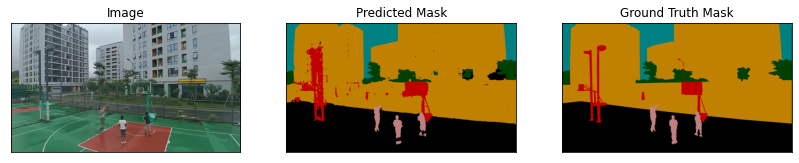

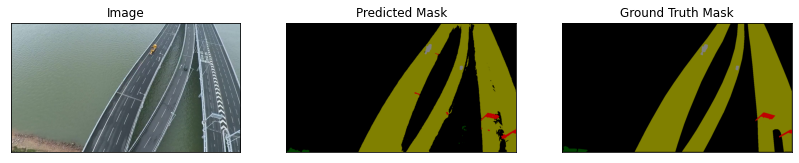

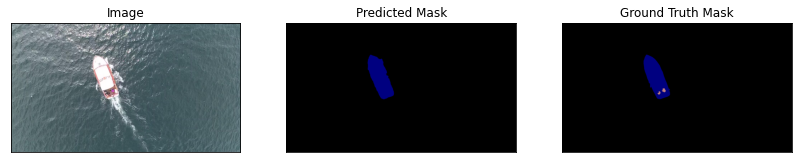

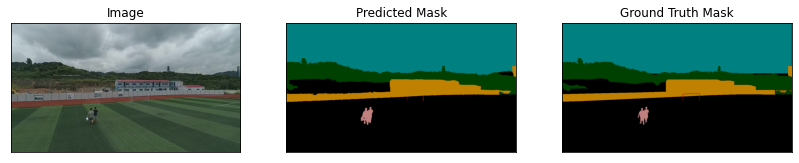

In [37]:
def predict(image_dict, visualize=True):
    #pr_mask = inferencer.predict_mask(image_dict)
    pr_mask = inferencer.predict(image_dict, activation="argmax").cpu().numpy()
    if visualize:
        Visualizer.visualize_images(
            image = image_dict["image_path"],
            predicted_mask = pr_mask,
            ground_truth_mask = image_dict["mask_path"]
        )
    return pr_mask


inferencer = Inferencer(cfg)
for image_dict in random.sample(inferencer.valid_image_dict_list, 4):
    predict(image_dict, visualize=True)

In [38]:
def evaluate_model(data_loader):
    metrics = IouAndDiceMetrics(Data.num_classes)
    pbar_loader = tqdm(data_loader)
    for images, gt_masks in pbar_loader:
        images = images.to(inferencer.device)
        gt_masks = gt_masks.narrow(2, 8, 720).to(inferencer.device)
        pr_masks = inferencer.predict(images)
        metrics.add(pr_masks, gt_masks)
        iou, _ = metrics.iou
        dice, _ = metrics.dice
        pbar_loader.set_postfix(iou=f"{iou:.03f}", dice=f"{dice:.03f}")
    pbar_loader.close()
    return metrics

def print_metrics(metrics):
    mean_iou, per_class_iou = metrics.iou
    print("  IoU Coefficients ")
    print("-------------------")
    print(f"        Mean: {mean_iou:.03f}")
    for class_name, class_iou in zip(Data.classes, per_class_iou):
        print(f"{class_name:>12}: {class_iou:.03f}")
    print()

    mean_dice, per_class_dice = metrics.dice
    print(" Dice Coefficients ")
    print("-------------------")
    print(f"        Mean: {mean_dice:.03f}")
    for class_name, class_dice in zip(Data.classes, per_class_dice):
        print(f"{class_name:>12}: {class_dice:.03f}")




In [39]:
valid_metrics = evaluate_model(inferencer.valid_net_loader)
print_metrics(valid_metrics)

100%|██████████████████| 262/262 [02:03<00:00,  2.12it/s, dice=0.903, iou=0.871]

  IoU Coefficients 
-------------------
        Mean: 0.871
  Background: 0.710
      Person: 0.773
        Bike: 0.839
         Car: 0.954
       Drone: 0.959
        Boat: 0.975
      Animal: 0.962
    Obstacle: 0.736
Construction: 0.822
  Vegetation: 0.904
        Road: 0.848
         Sky: 0.966

 Dice Coefficients 
-------------------
        Mean: 0.903
  Background: 0.771
      Person: 0.845
        Bike: 0.889
         Car: 0.970
       Drone: 0.969
        Boat: 0.977
      Animal: 0.967
    Obstacle: 0.807
Construction: 0.869
  Vegetation: 0.934
        Road: 0.867
         Sky: 0.969


# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [56]:
loader = inferencer.test_net_loader
it = iter(loader)
for i in range(3):
    images, _ = next(it)
    print(type(images), images.size())

<class 'torch.Tensor'> torch.Size([2, 3, 736, 1280])
<class 'torch.Tensor'> torch.Size([2, 3, 736, 1280])
<class 'torch.Tensor'> torch.Size([2, 3, 736, 1280])


In [41]:
class Submission(object):
    root_dir = "./submissions"
    csv_fields = ("ImageID", "EncodedPixels")
    
    @classmethod
    def __encode(cls, binary_array):
        from itertools import accumulate, groupby

        # compute the length of "0" and "1" pixel runs
        lengths = []
        for i, (value, elements) in enumerate(groupby(binary_array.ravel())):
            if i == 0 and value == 1:
                lengths.append(0)
            lengths.append(len(list(elements)))

        # compute the offsets of the pixel runs
        offsets = list(accumulate([0] + lengths))[:-1]

        # discard the offsets and lengths that correspond to the "0" pixels
        lengths = lengths[1::2]
        offsets = offsets[1::2]

        # interleave the offsets and lengths and convert to a string
        encoding = [val for pair in zip(offsets, lengths) for val in pair]
        return ' '.join(map(str, encoding))
    
    @classmethod
    def create(cls, fname, iterable):
        import csv
        os.makedirs(Submission.root_dir, exist_ok=True)
        path = os.path.join(Submission.root_dir, fname)
        with open(path, 'w') as file:
            writer = csv.writer(file)
            writer.writerow(Submission.csv_fields)
            pbar_test_iter = tqdm(iterable, desc="Encoding", unit="image")
            for name, pred in pbar_test_iter:
                rows = [(f"{name}_{idx}", cls.__encode(ba)) for idx, ba in enumerate(pred)]
                writer.writerows(rows)
            pbar_test_iter.close()
    

class SubmissionInferenceIterable(object):
    def __init__(self, inferencer):
        self.__inferencer = inferencer
        self.__image_ids = [d["name"] for d in Data.instance.get_prv_image_dict_list()]
    def __len__(self):
        return Data.prv_image_dict_len
    def __iter__(self):
        name_iter = iter(self.__image_ids)
        for images, _ in self.__inferencer.test_net_loader:
            preds = self.__inferencer.predict(images, activation="one_hot").cpu().numpy()
            for pred in preds:
                name = next(name_iter)
                yield name, pred


In [57]:
Submission.create("submission.csv", SubmissionInferenceIterable(inferencer))

Encoding: 648image [18:22,  1.70s/image]


# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

 

My Kaggle profile
https://www.google.com/url?q=https://www.kaggle.com/mohammedhamdan&sa=D&source=hangouts&ust=1638995699945000&usg=AOvVaw3dWTDknHZrjho6MXDjeqsm

 